<a href="https://colab.research.google.com/github/souvikg544/CodeNCollab/blob/main/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import seaborn as sns
import warnings
import os
from datetime import datetime
from hypopt import GridSearch

warnings.filterwarnings("ignore")

### Functions

In [ ]:
def percentage_rmse(y_true, y_pred):
    """
    Return RMSE calculation
    Params:
    ------
    
    - y_true: Test vector
    - y_pred: Predicted vector
    
    """
    return sqrt(np.square(y_true-y_pred).sum(axis=0)/y_true.shape[0])

def compute_metrics(y_true,y_pred):
    """
    Return relevant percentage metrics
    Params:
    ------
    
    - y_true: Test vector
    - y_pred: Predicted vector
    
    """
    mse=np.square(y_true-y_pred).sum(axis=0)/y_true.shape[0]
    rmse=sqrt(mse)
    mae=np.abs(y_true-y_pred).sum(axis=0)/y_true.shape[0]
    
    return {"RMSE":[rmse], "MSE":[mse], "MAE":[mae]}

We use a regression model to model the power curve

### Parameters

In [ ]:
metrics_filename="metrics.csv"
models={}
metrics_model={}
metric_columns=["date","model","params","best_train_score","RMSE","MSE","MAE","WithCrossVal"]

## Grid search with Cross validation

### Loading Data

In [ ]:
train_data=pd.read_csv("data/train_prep.csv")
test_data=pd.read_csv("data/test_prep.csv")
dev_data=pd.read_csv("data/dev_prep.csv")
#Check if metrics file exists
if os.path.isfile('./'+metrics_filename):
    metrics=pd.read_csv(metrics_filename)
else:
    metrics=pd.DataFrame(columns=metric_columns)

### Training model

In [ ]:
label_column="POWER"
columns=list(train_data.columns)
columns.remove(label_column)
columns.remove('TIMESTAMP')

In [ ]:
X_train=train_data[columns]
y_train=train_data[label_column]

X_test=test_data[columns]
y_test=test_data[label_column]

X_val=dev_data[columns]
y_val=dev_data[label_column]

### Lasso Model

In [ ]:
#Parameters
model_name="Lasso"
alphas=[1e-2, 1e-1,1]
max_iters=[100,1000,10000]
K=5
grid_values={"alpha":alphas,"max_iter":max_iters}
model=Lasso()

#Grid Search Cross validation
grid_model = GridSearchCV(model, param_grid = grid_values,scoring = make_scorer(percentage_rmse, greater_is_better=False),cv=K)
grid_model.fit(X_train,y_train)

#Save model and best score
models[model_name]=grid_model
metrics_model[model_name]=grid_model.best_score_

#Prediction on test set 
y_pred=grid_model.predict(X_test)

# Calculate metrics
dict_metrics=compute_metrics(y_test,y_pred)
metrics_model[model_name]=dict_metrics
dict_metrics["date"]=[datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
dict_metrics["model"]=["Lasso"]
dict_metrics["params"]=[grid_model.best_params_]
dict_metrics["best_train_score"]=[-grid_model.best_score_]
dict_metrics["WithCrossVal"]=["Yes"]
lr_metrics=pd.DataFrame.from_dict(dict_metrics)
lr_metrics=lr_metrics[metric_columns]
metrics=metrics.append(lr_metrics,ignore_index=True)
print('Metrics\n',metrics.tail(1))

Metrics
                     date  model                             params  \
37  10/24/2020, 00:11:16  Lasso  {'alpha': 0.01, 'max_iter': 1000}   

   best_train_score      RMSE        MSE       MAE WithCrossVal  
37         0.265113  0.264296  0.0698523  0.221629          Yes  


### Residuals Plot

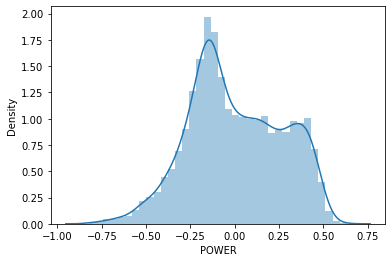

In [ ]:
sns.distplot(y_pred-y_test)
plt.show()

One of the main hypothesis for our linear regression is the normality of the residuals. 
However we can see from the plot above that the residuals are clearly not following a normal distribution. It seems that the models tends to overestimate the predictions and there's clearly a bias since the distribution is not symmetrical around 0. Let's try out a more complex model.

### Random Forest

In [ ]:
model_name="RF"
max_depths=[5,10,15]
num_trees=[10,50]
K=5
grid_values={"n_estimators":num_trees,"max_depth":max_depths}

model=RandomForestRegressor(random_state=42)
grid_model = GridSearchCV(model, param_grid = grid_values,scoring = make_scorer(percentage_rmse, greater_is_better=False),cv=K)
grid_model.fit(X_train,y_train)

#Save model and best score
models[model_name]=grid_model

#Prediction on test set 
y_pred=grid_model.predict(X_test)

# Calculate metrics
dict_metrics=compute_metrics(y_test,y_pred)
#Save metrics with model
metrics_model[model_name]=dict_metrics
#Add other metrics
dict_metrics["date"]=[datetime.now().strftime("%m/%d/%Y, %H:%M:%S")]
dict_metrics["model"]=[model_name]
dict_metrics["params"]=[grid_model.best_params_]
dict_metrics["best_train_score"]=[-grid_model.best_score_]
dict_metrics["WithCrossVal"]=["Yes"]
rf_metrics=pd.DataFrame.from_dict(dict_metrics)
rf_metrics=rf_metrics[metric_columns]
metrics=metrics.append(rf_metrics,ignore_index=True)
print('Metrics\n',metrics.tail(1))

Metrics
                     date model                                 params  \
38  10/24/2020, 00:12:14    RF  {'max_depth': 10, 'n_estimators': 50}   

   best_train_score      RMSE        MSE      MAE WithCrossVal  
38         0.130644  0.130742  0.0170935  0.09599          Yes  


### Residuals Plot

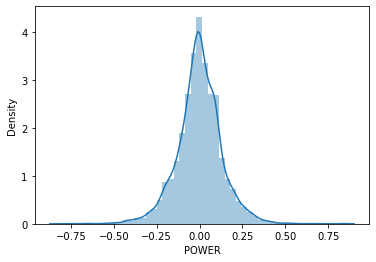

In [ ]:
sns.distplot(y_pred-y_test)
plt.show()

The residuals distribution is a lot more similar to a normal distribution that it was with our first model. 

### Pick Best model

In [ ]:
score="RMSE"
best_model=models[min(metrics_model, key=lambda x:metrics_model[x][score])]
print("best_model: ", best_model)

best_model:  GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(percentage_rmse, greater_is_better=False),
       verbose=0)


### Export metrics file

In [ ]:
metrics.to_csv('metrics.csv',mode='a',header=True,index=False)